## Authors:
#### Daniel Stöckein (5018039), Alexander Triol (5018451)

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
%matplotlib inline
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Load Data

In [7]:
images_dir = '../datasets/MixedMNIST/images/train'
images = ImageFolder(images_dir, transform=transforms.ToTensor())

In [42]:
images[99554][1]

4

In [15]:
images[0][0].shape

torch.Size([3, 28, 28])

In [12]:
print(len(images))

240000


In [25]:
print(images.class_to_idx)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


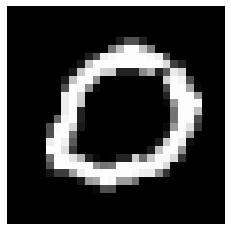

In [39]:
plt.imshow(images[0][0].T)
plt.axis('off')
plt.show()

<Figure size 432x288 with 0 Axes>

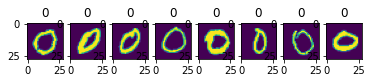

In [41]:
plt.figure()
f, axarr = plt.subplots(1,8)
for i in range(8):
    image, label = images[i]
    axarr[i].imshow(image[0])
    axarr[i].set_title(label)

In [35]:



dataloader = DataLoader(images, batch_size=16, shuffle=True)
img, labels = next(iter(images))
img = img.numpy()

fig = plt.figure(figsize=(25, 4))
img
#for idx in np.arange(10):
#    plt.imshow(img[idx])

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

<Figure size 1800x288 with 0 Axes>

In [14]:
df = pd.read_csv('../datasets/MixedMNIST/train.csv')
df


,id,image,classification
0,0,2_000000.png,7
1,1,0_000001.png,2
2,2,1_000002.png,7
3,3,3_000003.png,4
4,4,1_000004.png,3
...,...,...,...
239995,239995,2_239995.png,4
239996,239996,1_239996.png,5
239997,239997,3_239997.png,7
239998,239998,3_239998.png,1
